### QSVT for solving Quantum Linear System Problem (QLSP)

> Please read [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859) and watch [Isaac Chuang - Grand unification of quantum algorithms](https://www.youtube.com/watch?v=GFRojXdrVXI&t=1500s) for more information!

The normalized state

$$
A^{-1}|b\rangle / \|A^{-1}|b\rangle\|
$$

is the outcome of measurement with probability

$$
\| {1\over 2\kappa}A^{-1}|b\rangle\|^2,
$$

where $\kappa$ is the condition number of $A$ (under ideal circumstances).

In [75]:
from qiskit.quantum_info import Statevector
from qsvt.algorithms import linear_solver
from qsvt.helper import circulant_matrix, random_matrix
import numpy as np

import time

# matrix size exponent
N = 1

In [76]:
# Generate a random circulant matrix.
# A = circulant_matrix(N)
A = random_matrix(N)

In [77]:
# A = np.array([
#     [1, -1/3],
#     [-1/3, 1]
# ])

# A = np.array([
#      [1, 2, 3, 4],
#      [4, 1, 2, 3],
#      [3, 4, 1, 2],
#      [2, 3, 4, 1]]
# , dtype=float)

# A = np.array([
#     [1, 2, 3, 4, 5, 6, 7, 8],
#     [2, 3, 4, 5, 6, 7, 8, 1],
#     [3, 4, 5, 6, 7, 8, 1, 2],
#     [4, 5, 6, 7, 8, 1, 2, 3],
#     [5, 6, 7, 8, 1, 2, 3, 4],
#     [6, 7, 8, 1, 2, 3, 4, 5],
#     [7, 8, 1, 2, 3, 4, 5, 6],
#     [8, 1, 2, 3, 4, 5, 6, 7]
# ], dtype=float)

In [78]:
# normalize
A_norm = np.linalg.norm(A)
A /= A_norm

# Calculating condition number is time-consuming for large matrices.
# kappa = np.linalg.cond(A)
# print(f'kappa: {kappa}')

st = time.time()
qc = linear_solver(A)
# qc = linear_solver(A, set_degree=3)
# qc = linear_solver(A, amplify='chebyshev')
# qc = linear_solver(A, amplify='sign')
# qc = linear_solver(A, amplify='AA')
ed = time.time()
print(f'prepare circuit spends: {ed - st} sec')

# qc.draw('mpl')

deg: 121
prepare circuit spends: 0.0595850944519043 sec


In [79]:
st = time.time()
state = Statevector(qc)
ed = time.time()
print(f'prepare state snapshot spends: {ed - st} sec')

n = qc.num_qubits
print(f'number of qubits: {n}')

# for AA
# measure_qubits = [n - 3, n - 2]
# exp_outcome = "00"

# for no AA
measure_qubits = [n - 2, n - 1]
exp_outcome = "00"

# for no AA and no real_only
# measure_qubits = [n - 1]
# exp_outcome = "0"

st = time.time()
while True:
    outcome, mstate = state.measure(measure_qubits)
    if outcome == exp_outcome: break
ed = time.time()
print(f'post-measurement state: {mstate}')
print(f'post-selection spends: {ed - st} sec')

############## solve by singular values ################
# fS = 1 / S
# print(f'fS: {fS}')

# fAd = np.conj(Vd.T) * fS @ np.conj(W.T) # A^\dagger
# print(f'fAd: {fAd}')


# res = np.array(fAd[:, 0])
########################################################

# # for AA: 3 ancilla qubits
# res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 3) - 1)))

# for no AA: 2 ancilla qubits
res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 2) - 1)))

# for no AA and no real_only: 1 ancilla qubits
# res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 1) - 1)))

res /= np.linalg.norm(res)
print(f'res: {res}')

prepare state snapshot spends: 0.05538344383239746 sec
number of qubits: 3
post-measurement state: Statevector([-0.57556567+2.55774155e-17j,  0.81775556-4.31525307e-17j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
              0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
            dims=(2, 2, 2))
post-selection spends: 0.01944565773010254 sec
res: [ 0.59021169 -0.80724851]


In [80]:
# Calculate total variance
from qsvt.helper import total_variation

P = np.array([mstate[i] for i in range(2 ** N)])
P = np.array([np.linalg.norm(x)**2 for x in P])
print(f'P: {P}')
Q = np.array([x ** 2 for x in res])
print(f'Q: {Q}')

# print(f'kappa: {kappa}')
print(f'total_variation (exact): {total_variation(P, Q)}')

P: [0.33127585 0.66872415]
Q: [0.34834984 0.65165016]
total_variation (exact): 0.01707399165950635


time: 0.03427696228027344 sec


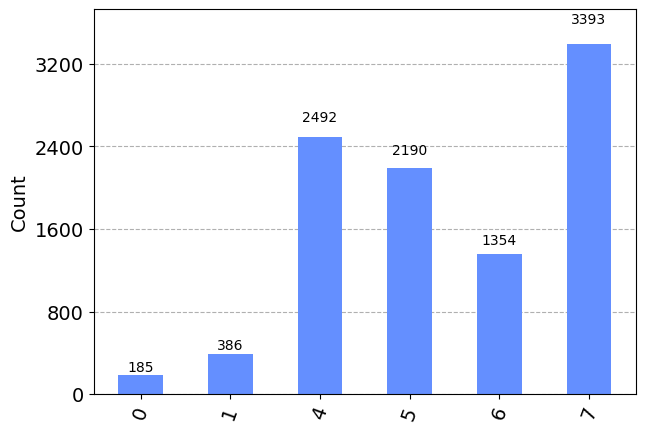

In [81]:
# Self-sampling (instead of running on a "simulator backend")
from qiskit.visualization import plot_histogram

st = time.time()
state = Statevector(qc)
P = np.array([np.linalg.norm(x)**2 for x in state])
shots = 10000
# counts = {}

# print(len(state), len(list(range(2 ** N))))
a = np.random.choice(a=list(range(2 ** n)), p=P, size=shots)
a = np.sort(a)
unique_elements, counts = np.unique(a, return_counts=True)
counts = dict(zip(unique_elements, counts))
# print(a)

##### Use `Statevector()` to run 10000 shots (SLOW!!!) #####
# for _ in range(shots):
#     outcome, tmp_state = state.measure(list(range(n)))
#     if counts.get(outcome) == None:
#         counts[outcome] = 0
#     else:
#         counts[outcome] += 1

ed = time.time()
print(f'time: {ed - st} sec')
plot_histogram(counts)

qc depth: 486


transpilation spends: 0.11442327499389648 sec
transpiled qc depth: 727
run job spends: 0.031001806259155273 sec


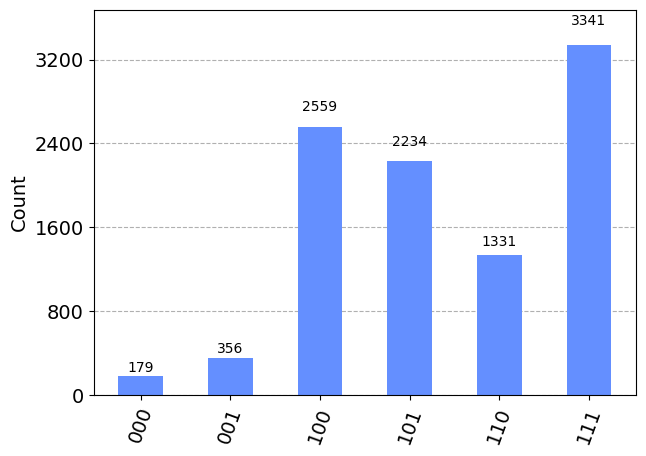

In [82]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# cr = ClassicalRegister(len(measure_qubits))
# qc.add_register(cr)
# qc.measure(measure_qubits, cr)
qc.measure_all()
print(f'qc depth: {qc.depth()}')

# It seems that even if 'GPU' is specified, GPU is not used at all. (2023/07)
# Since QSVT involves large multi-qubit gates (block-encoding), "extended_stabilizer" is not efficient.
# sim = AerSimulator(method='extended_stabilizer')
sim = AerSimulator(method='statevector')
# sim = AerSimulator(method='statevector', device='GPU')

st = time.time()
transpiled_circuit = transpile(qc, sim)
# transpiled_circuit = transpile(qc, sim, optimization_level=3)
ed = time.time()
print(f'transpilation spends: {ed - st} sec')
# transpiled_circuit = transpile(qc, sim, optimization_level=3)
print(f'transpiled qc depth: {transpiled_circuit.depth()}')


# run job
shots = 10000
st = time.time()
job = sim.run(transpiled_circuit, shots=shots, dynamic=True, blocking_enable=True, blocking_qubits=10)
ed = time.time()

print(f'run job spends: {ed - st} sec')
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

In [83]:
# Calculate total variance
from qsvt.helper import total_variation

# experiment count
# print(f'exp_counts: {exp_counts}')
valid_count = np.zeros(shape=(2 ** N))
success = 0
for data in exp_counts:
    # print(f'data: {data[:]}')
    if data[:2] == '00':
        success += exp_counts[data]
        valid_count[int(data[2:], base=2)] = exp_counts[data]
valid_count /= shots
valid_count /= np.linalg.norm(valid_count)
# print(f'valid_count: {valid_count}')

# Q = np.array([x ** 2 for x in res])
# print(f'Q: {Q}')

# print(f'kappa: {kappa}')
print(f'success probability: {success / shots}')
print(f'total_variation (exp): {total_variation(valid_count, Q)}')

success probability: 0.0535
total_variation (exp): 0.17132062524192473


In [84]:
# # Sampler  (slow and "quasi")
# from qiskit.circuit.random import random_circuit 
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler 

# service = QiskitRuntimeService() 

# # Run on a simulator
# backend = service.get_backend("ibmq_qasm_simulator")
# # Or use the next line if you want to run on a system instead of a simulator:
# # backend = service.least_busy(simulator=False)

# # circuit = random_circuit(2, 2, seed=1234) 
# # circuit.measure_all() 

# sampler = Sampler(backend) 
# job = sampler.run(qc) 
# result = job.result() 

# print(qc) 
# print(f" > Quasi probability distribution: {result.quasi_dists}") 
# print(f" > Metadata: {result.metadata}") 

In [85]:
# # remote backend
# from qiskit_ibm_provider import IBMProvider

# hub="ibm-q"; group="open"; project="main"

# # token = 'TOKEN'
# # IBMProvider.save_account(token)

# provider = IBMProvider()
# # This doesn't work
# # backend_name = "simulator_extended_stabilizer" 
# backend_name = "simulator_statevector"
# # backend_name = "ibm_perth"
# provider_backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
# print(provider_backend.name)

In [86]:
# # run job remotely
# shots = 10000
# st = time.time()
# transpiled_circuit = transpile(qc, provider_backend)
# # transpiled_circuit = transpile(qc, provider_backend, optimization_level=3)
# ed = time.time()
# print(f'transpilation spends: {ed - st} sec')
# print(f'transpiled qc depth: {transpiled_circuit.depth()}')

# # job = provider_backend.run(transpiled_circuit, shots=shots)
# job = provider_backend.run(qc, shots=shots)

# print('job submitted!')

# # Get the results and display them
# exp_result = job.result()
# exp_counts = exp_result.get_counts()
# plot_histogram(exp_counts)

In [87]:
# # Run on AWS Braket (error)
# from qiskit_braket_provider import AWSBraketProvider

# provider = AWSBraketProvider()

# # devices
# device = provider.get_backend("Lucy")
# print(device)

# task = device.run(qc, shots=100)

# arn = task.job_id()
# retrieved = device.retrieve_job(job_id=arn)

# print(retrieved.status())
# plot_histogram(retrieved_job.result().get_counts())

In [88]:
# # basis gates
# aer_config = sim.configuration()
# aer_basis_gates = aer_config.basis_gates
# print(len(aer_basis_gates))

# config = provider_backend.configuration()
# basis_gates = config.basis_gates
# print(len(basis_gates))

# aer_basis_gates.sort()
# basis_gates.sort()
# print(aer_basis_gates)
# print(basis_gates)

# for gate in basis_gates:
#     if gate not in aer_basis_gates:
#         print(f'{gate} not in aerSim')
# for gate in aer_basis_gates:
#     if gate not in basis_gates:
#         print(f'"{gate}" not in Sim')